# Hierachical Risk Parity Investment Strategy
## Use ETF of representative asset classes
#### Developed-Emerging Equity, Sector ,Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included
### Resuld is driven from 2012 to 2021 market data

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import os
os.chdir(os.path.join('/mnt','c','workspace','project_quant'))

In [22]:
import pandas as pd
import numpy as np

from utils.yahoo_stock_data import yahoo_data
from utils.regular_rebalancing import monthly_rebalance_strategy

%matplotlib inline
from matplotlib import pyplot as plt

import quantstats

from scipy.cluster.hierarchy import dendrogram, linkage

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [25]:
asset_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "VEA",  # Vanguard FTSE Developed Markets ETF                   2007-07-02
    "VWO",  # Vanguard FTSE Emerging Markets ETF                    2005-03-04
    "TLT",  # iShares 20+ Year Treasury Bond ETF                    2002-07-22
    "TIP",  # iShares TIPS Bond ETF                                 2003-12-04
    "LQD",  # iShares iBoxx $ Investment Grade Corporate Bond ETF   2002-07-22
    "DBC",  # Invesco DB Commodity Index Tracking Fund              2006-02-03
    "XAR",  # SPDR® S&P® Aerospace & Defense ETF                    2011-09-28
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    "RWR",  # SPDR® Dow Jones® REIT ETF                             2001-04-23
    "RWX"   # SPDR® Dow Jones® International Real Estate ETF        2006-12-15
    ]

bm_class_ticker =[
    "IVV",  # iShares Core S&P 500 ETF                              2000-05-15
    "AGG",  # iShares Core U.S. Aggregate Bond ETF                  2002-07-22
    ]

In [26]:
# for monthly rebalance strategy
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-01-31',
    'ticker_list': asset_class_ticker,
    'rebal_period' : '1M',
    }

data = yahoo_data(**data_setting)
yield_df = data.yahoo_stock_data_loading()

# to draw benchmark
data_setting = {
    'start' : '2013-02-01',
    'end' : '2022-01-31',
    'ticker_list': bm_class_ticker,
    'rebal_period' : '1M',
    }

data = yahoo_data(**data_setting)
benchmark_yield_df = data.yahoo_stock_data_loading()

In [27]:
def _60_40_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'IVV'] = 0.600
    weights.loc[:,'AGG'] = 0.400
    return weights

In [ ]:
def all_weather_strategy(yld_df):
    weights = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    weights.loc[:,'VTI'] = 0.300
    weights.loc[:,'TLT'] = 0.400
    weights.loc[:,'IEI'] = 0.150
    weights.loc[:,'GLD'] = 0.075
    weights.loc[:,'GSG'] = 0.075
    return weights

In [28]:
def hierachical_rp_portfolio(yld_df):
    asset_cov = yld_df.cov()
    asset_corr = yld_df.corr()

    # distance matrix
    d_corr = (np.sqrt(0.5*(1-asset_corr))).fillna(0)
    link_corr = linkage(d_corr,'single')
    z = pd.DataFrame(link_corr)

    sort_index = get_quasi_diag(link_corr)
    weights = get_rec_bipart(cov=asset_cov, sort_ix=sort_index)
    weights.index = [yld_df.columns[i] for i in weights.index]
    return weights

def get_quasi_diag(link):
    # sort clustered items by distance
    link = link.astype(int)

    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]])

    # the total num of items is the third item of the last list
    num_items = link[-1,3]

    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # make space
        df0 = sort_ix[sort_ix >= num_items] # find clusters

        # df0 contains even index and cluster index
        i = df0.index
        j = df0.values - num_items
        sort_ix[i] = link[j,0] # item 1

        df0  = pd.Series(link[j, 1], index=i+1)
        sort_ix = sort_ix.append(df0) # item 2
        sort_ix = sort_ix.sort_index()
        sort_ix.index = range(sort_ix.shape[0])
    return sort_ix.tolist()

def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inverse-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)

    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        c_items = [i[int(j):int(k)] for i in c_items for j,k in
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]

        # parse in pairs
        for i in range(0, len(c_items), 2):

            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2

            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)

            alpha = 1 - c_var0/(c_var0+c_var1)

            w[c_items0] *= alpha
            w[c_items1] *=1-alpha

    return w

## Testing with 2021 market data.
#### visualize hierachical structure of asset classes.
#### visualize pie chart of model portfolio

In [29]:
# correlation matrix
yield_df_test=yield_df.loc['2021-01-01':'2021-12-31']
asset_cov = yield_df_test.cov()
asset_corr = yield_df_test.corr()

# distance matrix
d_corr = (np.sqrt(0.5*(1-asset_corr))).fillna(0)
link_corr = linkage(d_corr, 'single')
Z = pd.DataFrame(link_corr)

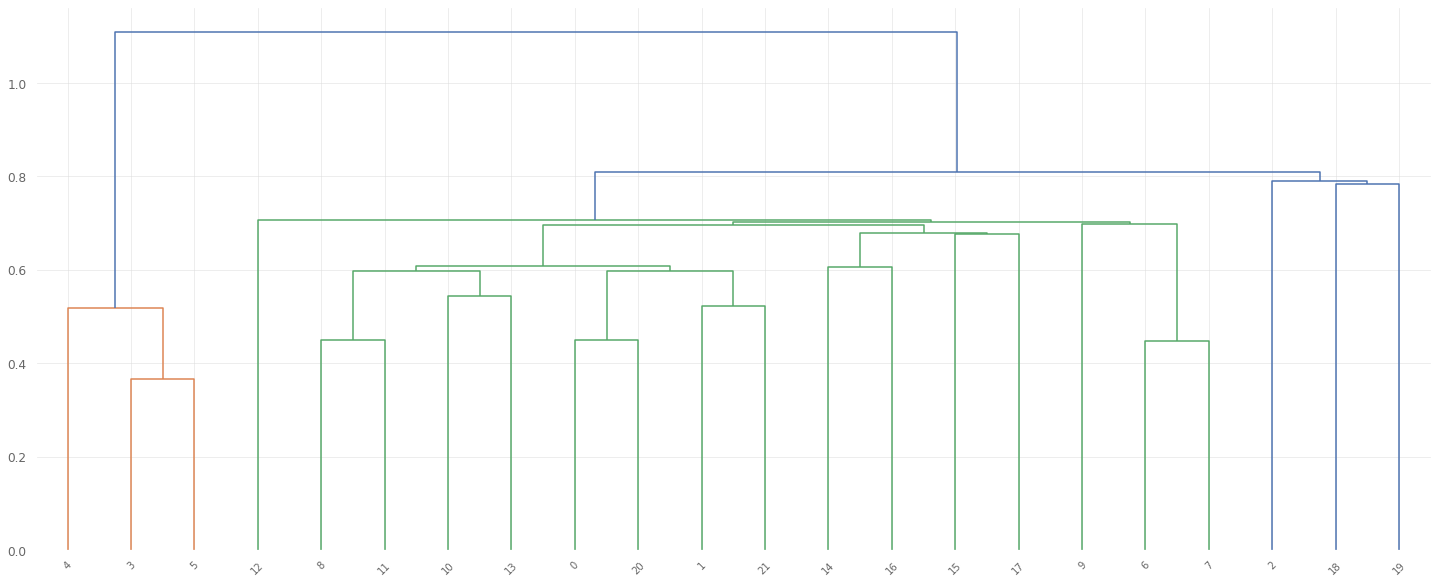

In [30]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()

In [31]:
sort_index = get_quasi_diag(link_corr)
weights = get_rec_bipart(cov=asset_cov, sort_ix=sort_index)
weights.index = [yield_df_test.columns[i] for i in weights.index]

<BarContainer object of 22 artists>

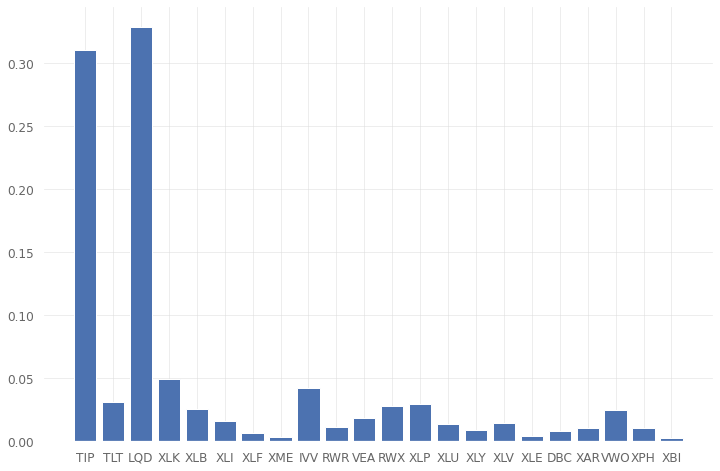

In [32]:
plt.figure(figsize = (12, 8))
plt.bar(list(weights.index), weights)

([<matplotlib.patches.Wedge at 0x7fa86bd30fd0>,
 [Text(0.6183855745084677, 0.9097248382009984, 'TIP'),
  Text(-0.5037178159772294, 0.9778897493414737, 'TLT'),
  Text(-1.0993102626488667, -0.03894799654513521, 'LQD'),
  Text(-0.37454017471902734, -1.0342725257500756, 'XLK'),
  Text(-0.12121014311973062, -1.0933014685826112, 'XLB'),
  Text(0.022879145444067314, -1.0997620400358203, 'XLI'),
  Text(0.10078522980163758, -1.0953731498689527, 'XLF'),
  Text(0.13427049368602226, -1.091774443062903, 'XME'),
  Text(0.2893982803033228, -1.0612486208977987, 'IVV'),
  Text(0.46307763812941305, -0.997777079845235, 'RWR'),
  Text(0.5532822470083977, -0.9507253836651984, 'VEA'),
  Text(0.6853828077113143, -0.8603780604442188, 'RWX'),
  Text(0.8291137478162524, -0.7228903050823742, 'XLP'),
  Text(0.9204659010278691, -0.6022811013513153, 'XLU'),
  Text(0.9621769455361691, -0.5331186786060758, 'XLY'),
  Text(0.9998254085013156, -0.4586383679056711, 'XLV'),
  Text(1.0257094999674188, -0.3973915218982256, 

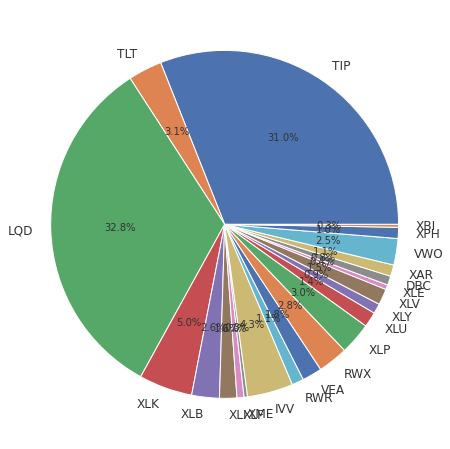

In [33]:
plt.figure(figsize = (12, 8))
plt.pie(weights, labels=list(weights.index), autopct='%.1f%%')

In [34]:
monthly_rebal_strategy=monthly_rebalance_strategy(
    strategy=hierachical_rp_portfolio, yld_df = yield_df,
    bm_strategy=_60_40_strategy, bm_yld_df = benchmark_yield_df,
    lookback_period=12
)
monthly_rebal_strategy

,strategy_return,benchmark_return,IVV,VEA,VWO,TLT,TIP,LQD,DBC,XAR,...,XME,XLP,XLY,XLU,XLV,XPH,XBI,RWR,RWX,SUM
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-28,-0.028265,-0.021551,0.226816,0.13218,0.122528,0.088929,0.012269,0.027058,0.020442,0.030605,...,0.0281,0.012271,0.016572,0.027559,0.028016,0.022171,0.034762,0.019548,0.007919,2.0
2014-03-31,0.054587,0.038588,0.137484,0.051632,0.032982,0.019909,0.031162,0.179116,0.183744,0.013071,...,0.028751,0.028185,0.021549,0.0269,0.015343,0.020688,0.043924,0.013855,0.006277,2.0
2014-04-30,0.001169,0.011093,0.121214,0.046472,0.030295,0.017884,0.027607,0.188306,0.216447,0.028099,...,0.022885,0.01226,0.01404,0.025649,0.019267,0.02476,0.028743,0.016288,0.008527,2.0
2014-05-31,0.006529,0.004621,0.11751,0.04434,0.030211,0.019709,0.02992,0.162427,0.229109,0.026989,...,0.029213,0.026052,0.02161,0.021402,0.010496,0.012345,0.037101,0.015343,0.011035,2.0
2014-06-30,0.017269,0.017754,0.121821,0.112622,0.178358,0.259951,0.009845,0.033217,0.016093,0.011545,...,0.02152,0.010261,0.019147,0.028476,0.012599,0.010595,0.029642,0.007941,0.00257,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,0.000314,0.017565,0.132052,0.101736,0.00725,0.03933,0.320508,0.038345,0.041913,0.191063,...,0.005214,0.025353,0.008286,0.012171,0.006798,0.00737,0.003769,0.004862,0.004826,2.0
2021-10-31,-0.006192,-0.026949,0.073874,0.150849,0.006873,0.034706,0.067783,0.362939,0.175616,0.004568,...,0.016131,0.002552,0.006758,0.013614,0.003748,0.003168,0.01488,0.004224,0.006895,2.0
2021-11-30,0.025031,0.033648,0.028592,0.256232,0.042576,0.45718,0.06036,0.00458,0.01611,0.003667,...,0.007036,0.002608,0.009767,0.016725,0.009355,0.006329,0.014764,0.00417,0.003606,2.0


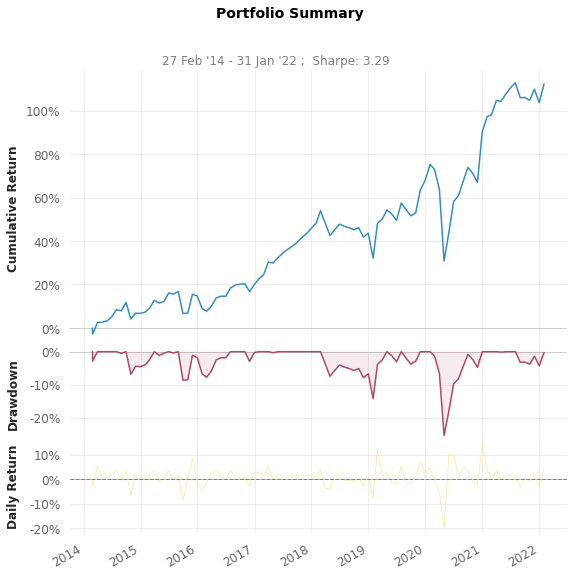

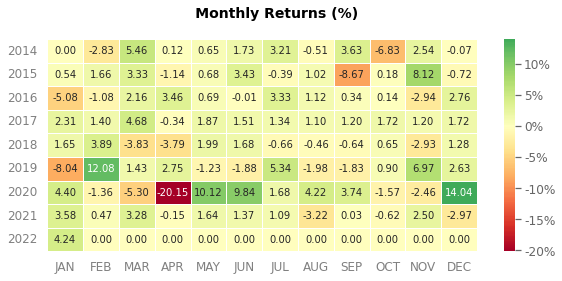

In [35]:
quantstats.reports.plots(returns = monthly_rebal_strategy.loc[ : , 'strategy_return'] , benchmark = monthly_rebal_strategy.loc[ : , 'benchmark_return'], mode='basic')

In [36]:
quantstats.reports.metrics(returns=monthly_rebal_strategy.loc[ : , 'strategy_return'], benchmark=monthly_rebal_strategy.loc[ : , 'benchmark_return'], mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2014-02-28  2014-02-28
End Period          2022-01-31  2022-01-31
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   112.29%     119.96%
CAGR﹪              9.96%       10.45%

Sharpe              3.31        5.03
Sortino             4.99        7.88
Sortino/√2          3.53        5.57
Omega               1.88        1.88

Max Drawdown        -25.41%     -14.22%
Longest DD Days     395         153

Gain/Pain Ratio     0.88        1.41
Gain/Pain (1M)      0.88        1.41

Payoff Ratio        0.79        0.86
Profit Factor       1.88        2.41
Common Sense Ratio  2.66        4.26
CPC Index           0.97        1.5
Tail Ratio          1.41        1.77
Outlier Win Ratio   3.35        4.73
Outlier Loss Ratio  2.56        3.28

MTD                 4.24%       3.19%
3M                  3.03%       2.57%
6M                  -0.25%      5.93

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2014-02-28  2014-02-28
End Period                 2022-01-31  2022-01-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          112.29%     119.96%
CAGR﹪                     9.96%       10.45%

Sharpe                     3.31        5.03
Smart Sharpe               3.05        4.64
Sortino                    4.99        7.88
Smart Sortino              4.61        7.28
Sortino/√2                 3.53        5.57
Smart Sortino/√2           3.26        5.15
Omega                      1.88        1.88

Max Drawdown               -25.41%     -14.22%
Longest DD Days            395         153
Volatility (ann.)          66.86%      43.2%
R^2                        0.82        0.82
Calmar                     0.39        0.73
Skew                       -0.87       -0.96
Kurtosis                   7.04        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-29,2020-04-30,2020-12-31,306,-25.407868,-17.857745
2,2018-03-31,2019-01-31,2019-04-30,395,-14.223275,-7.900747
3,2015-09-30,2015-09-30,2016-07-31,305,-8.666129,-8.500806
4,2014-10-31,2014-10-31,2015-03-31,151,-6.830869,-4.528414
5,2021-08-31,2021-12-31,2022-01-31,153,-4.309621,-3.785792


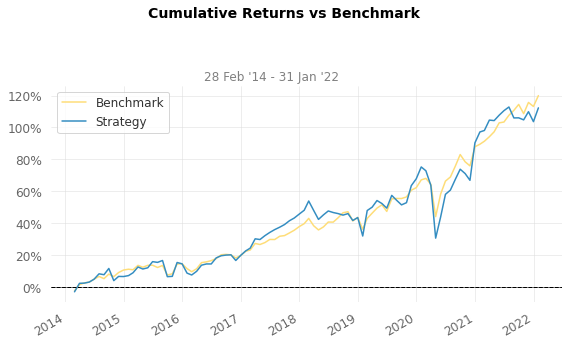

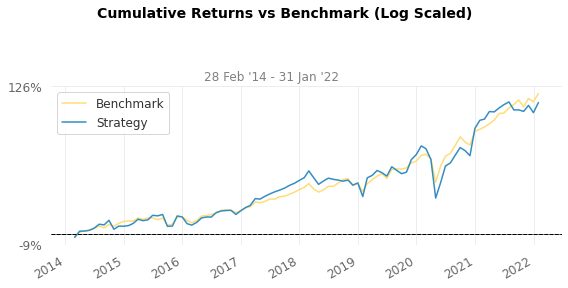

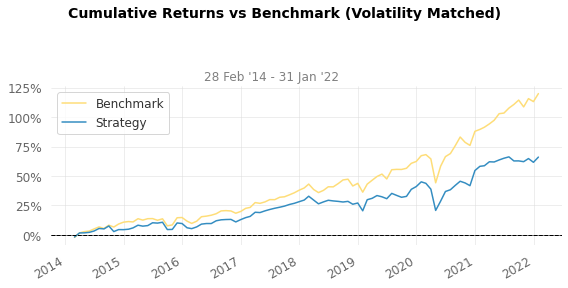

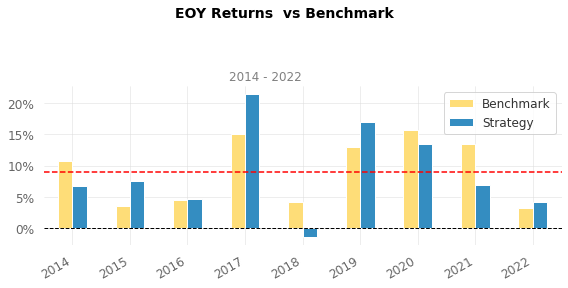

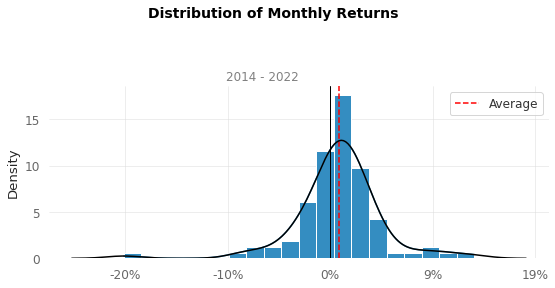

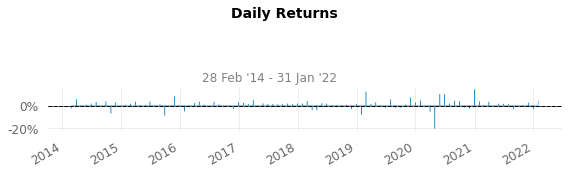

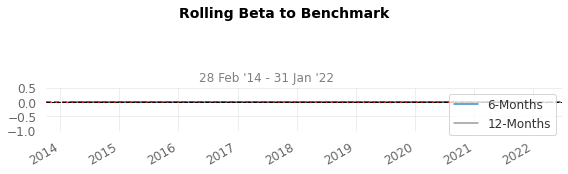

---


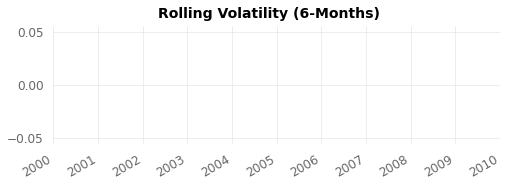

In [37]:
try:
    quantstats.reports.full(returns=monthly_rebal_strategy.loc[ : , 'strategy_return'], benchmark=monthly_rebal_strategy.loc[ : , 'benchmark_return'])
except:
    print("---")